In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import torch.nn as nn
from transformers import BertModel
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json 
import torch 
import random 
from ray.data.preprocessor import Preprocessor
#from ray.train.torch import get_device 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
import numpy as np
import os
import ray 
import logging
logging.getLogger('ray').setLevel(logging.ERROR)

In [91]:
from ray.air import  session
from ray.air.config import CheckpointConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train import  DataConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [5]:
import ray
if ray.is_initialized():
    ray.shutdown()
ray.init(
    log_to_driver=False,
    _metrics_export_port=None
)
import sys
sys.path.append("..")

2026-01-05 15:41:18,062	INFO worker.py:2023 -- Started a local Ray instance.
2026-01-05 15:41:18,107	INFO packaging.py:588 -- Creating a file package for local module '/Users/aravindrajeshmenon/Documents/DataScienceProjects/Projects/reddit_nlp_classification'.
2026-01-05 15:41:18,137	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_fa27167fd815edfc.zip' (3.74MiB) to Ray cluster...
2026-01-05 15:41:18,142	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_fa27167fd815edfc.zip'.


In [6]:
ray.cluster_resources()

{'CPU': 8.0,
 'object_store_memory': 1643171020.0,
 'node:127.0.0.1': 1.0,
 'memory': 3834065716.0,
 'node:__internal_head__': 1.0}

In [7]:
num_workers = 6 
resources_per_worker={"CPU": 1, "GPU": 0}

In [8]:
DATASET_LOC = os.path.join(os.getcwd(), 'data', 'reddit_posts_20251212_035106.parquet')

In [9]:
df = pd.read_parquet(DATASET_LOC)

In [10]:
df.head()

,post_id,title,subreddit
0,1pkhhxb,"Even the man behind ChatGPT, OpenAI CEO Sam Al...",technology
1,1pkh69t,"Palantir sues CEO of rival AI firm Percepta, a...",technology
2,1pkg053,'Architects of AI' named Time Magazine's Perso...,technology
3,1pkfqa0,Sam Altman expects OpenAI to exit ‘code red’ b...,technology
4,1pkfpmf,Broadcom reveals its mystery $10 billion custo...,technology


In [11]:
df['subreddit'].value_counts()

subreddit
entertainment            997
technology               989
science                  987
politics                 986
ArtificialInteligence    962
Name: count, dtype: int64

In [12]:
df = df.sample(frac = 1.0)

In [13]:
test_size = 0.2 
train_df, val_df = train_test_split(df, test_size = test_size, stratify = df['subreddit'], random_state = 13)
                                    

In [14]:
train_df['subreddit'].value_counts()

subreddit
entertainment            797
technology               791
politics                 789
science                  789
ArtificialInteligence    770
Name: count, dtype: int64

In [15]:
(val_df['subreddit'].value_counts() * (1-test_size))/(test_size)

subreddit
entertainment            800.0
science                  792.0
technology               792.0
politics                 788.0
ArtificialInteligence    768.0
Name: count, dtype: float64

## EDA 

Let us first visualise the number of examples per subreddit. 

In [16]:
counter = Counter(df['subreddit'])
counter.most_common()

[('entertainment', 997),
 ('technology', 989),
 ('science', 987),
 ('politics', 986),
 ('ArtificialInteligence', 962)]

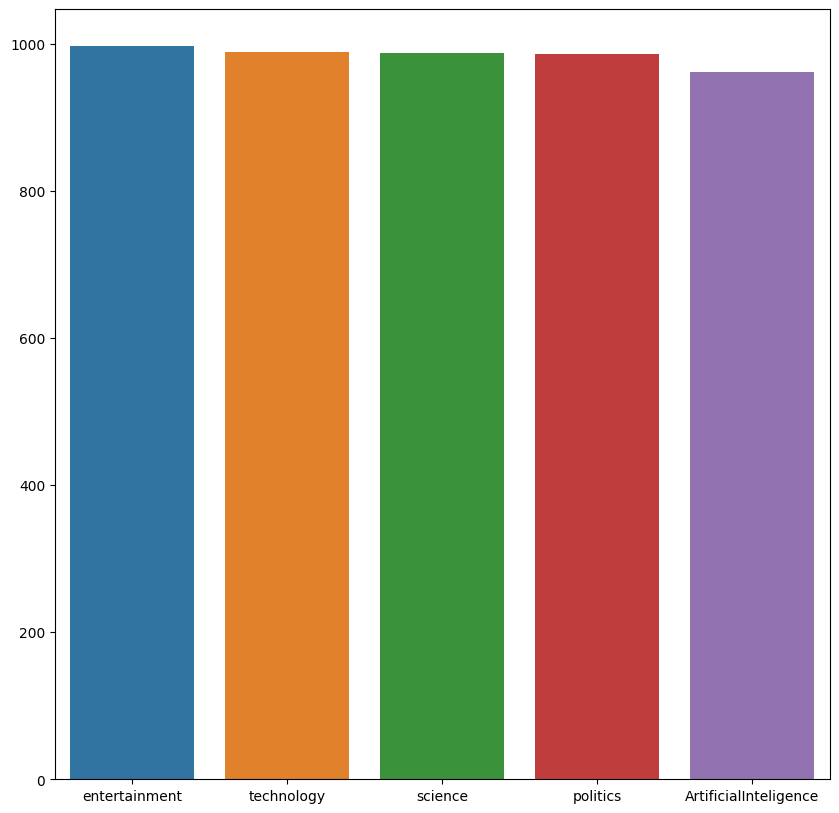

In [17]:
subreddit, counts = zip(*counter.most_common())
plt.figure(figsize = (10,10))
sns.barplot(x = list(subreddit), y = list(counts), hue = list(subreddit))
plt.show()

In [18]:
subreddits = df['subreddit'].unique().tolist()

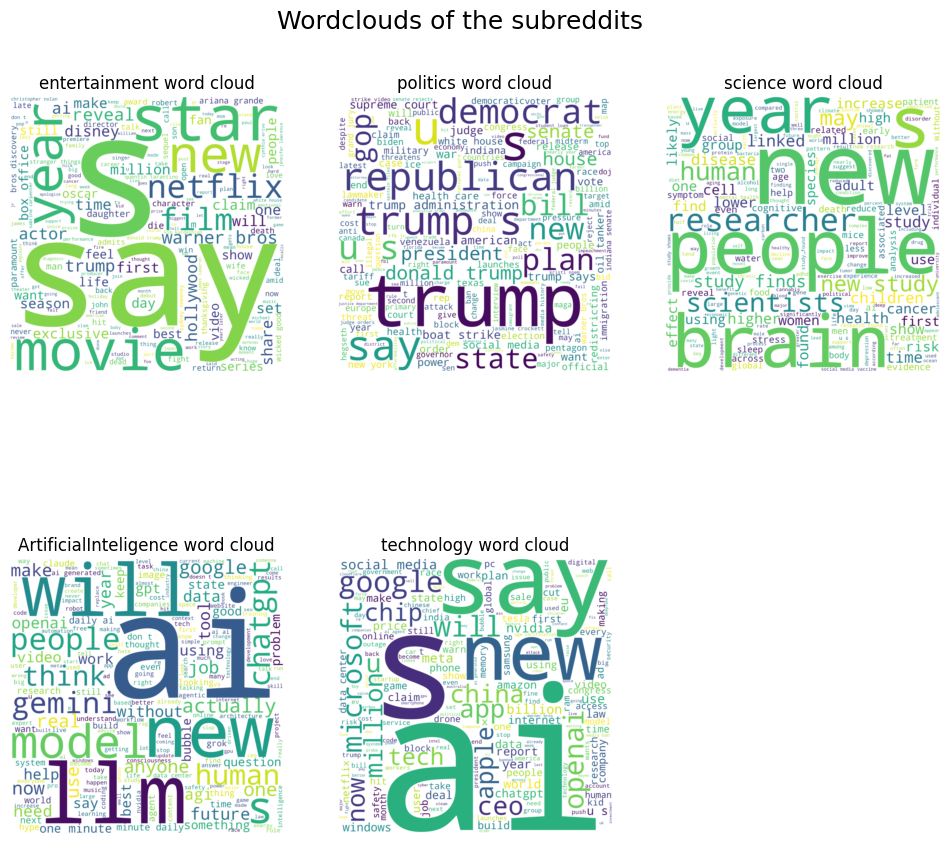

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Wordclouds of the subreddits", fontsize=18, y=0.95)

for sub, ax in zip(subreddits, axs.ravel()):
    stopwords = set(STOPWORDS)
    text = ' '.join(df[df['subreddit'] == sub]['title'].astype('str').tolist())
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    wordcloud = WordCloud(width=2000, height=2000, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sub} word cloud")
    ax.axis('off')

axs.ravel()[-1].axis('off')

plt.show()
        

In [20]:
def clean_text(text):
    stopwords = set(STOPWORDS)
    text = text.lower()
 
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text) 
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = text.strip()
    text = re.sub(r"http\S+", "", text)
    return text 
    

In [21]:
original_df = df.copy()
df['title'] = df['title'].map(clean_text)

In [22]:
print(original_df['title'][0])
print(df['title'][0])

Even the man behind ChatGPT, OpenAI CEO Sam Altman is worried about the ‘rate of change that’s happening in the world right now’ thanks to AI
even man behind chatgpt openai ceo sam altman worried rate change s happening world right now thanks ai


In [23]:
df = df.drop(columns = ['post_id'], axis = 1) 
df = df.dropna()

In [24]:
class_to_index = {k:i for i, k in enumerate(subreddits)}
class_to_index

{'entertainment': 0,
 'politics': 1,
 'science': 2,
 'ArtificialInteligence': 3,
 'technology': 4}

In [58]:
num_classes = len(subreddits) 

In [25]:
index_to_class = {v:k for k,v in class_to_index.items()}
index_to_class

{0: 'entertainment',
 1: 'politics',
 2: 'science',
 3: 'ArtificialInteligence',
 4: 'technology'}

In [26]:
def encode(indices, class_to_index):
    return [class_to_index[index] for index in indices]


In [27]:
encode(df.sample(5)["subreddit"].values, class_to_index=class_to_index)

[1, 3, 4, 1, 4]

In [28]:
df['subreddit'] = df['subreddit'].map(class_to_index)

In [29]:
df

,title,subreddit
2258,kevin hart embarrassingly begs applause world ...,0
4621,d c circuit keeps trump s transgender military...,1
1683,opt organ donation policies lead 1 21 million ...,2
3164,don t understand si hate,3
1922,programs teach adolescents cognitive behaviora...,2
...,...,...
3678,openai locks san francisco offices following a...,3
3542,ai predictions come true least yet,3
2558,vin diesel praises dwayne johnson partnership ...,0
4466,trump administration plans check 5 years socia...,1


In [30]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [31]:
decode(df.head()["subreddit"].values, index_to_class=index_to_class)

['entertainment', 'politics', 'science', 'ArtificialInteligence', 'science']

In [32]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [33]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch['title'].tolist(), padding = 'longest',return_tensors = 'pt')
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["subreddit"]))

In [34]:
def preprocess(df, class_to_index:dict):
    df['title'] = df['title'].map(clean_text)
    df = df.drop(columns = ['post_id'], axis = 1) 
    df = df.dropna()
    df['subreddit'] = df['subreddit'].map(class_to_index)
    outputs = tokenize(df)
    return outputs
    

In [35]:
train_inputs = preprocess(train_df, class_to_index)
val_inputs = preprocess(val_df, class_to_index)

In [36]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [37]:
ds = ray.data.read_parquet(DATASET_LOC)
ds = ds.random_shuffle(seed= 43)
ds.take(1)

Parquet dataset sampling 0:   0%|                                                                             …

[2026-01-05 15:41:50,070 E 95283 6160538] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-05 15:42:15,079	INFO parquet_datasource.py:728 -- Estimated parquet encoding ratio is 1.475.
2026-01-05 15:42:15,081	INFO parquet_datasource.py:788 -- Estimated parquet reader batch size at 1082402 rows
2026-01-05 15:42:18,632	INFO dataset.py:3485 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2026-01-05 15:42:18,653	INFO logging.py:397 -- Registered dataset logger for dataset dataset_2_0
2026-01-05 15:42:18,685	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 15:42:18,686	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_2_

Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- limit=1 5: 0.00 row [00:00, ? row/s]

2026-01-05 15:42:18,722	WARNING resource_manager.py:136 -- ⚠️  Ray's object store is configured to use only 42.9% of available memory (1.5GiB out of 3.6GiB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2026-01-05 15:42:19,129	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_2_0 execution finished in 0.44 seconds
2026-01-05 15:42:19,170	INFO util.py:257 -- Exiting prefetcher's background thread


[{'post_id': '1p6zlkq',
  'title': 'AI optimized content',
  'subreddit': 'ArtificialInteligence'}]

In [38]:
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

2026-01-05 15:42:19,183	INFO logging.py:397 -- Registered dataset logger for dataset dataset_3_0
2026-01-05 15:42:19,191	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 15:42:19,192	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|                                                                                              …

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- Project 5: 0.00 row [00:00, ? row/s]

- AggregateNumRows 6:   0%|                                                                                   …

2026-01-05 15:42:19,909	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_3_0 execution finished in 0.72 seconds
2026-01-05 15:42:19,919	INFO util.py:257 -- Exiting prefetcher's background thread
2026-01-05 15:42:19,924	INFO logging.py:397 -- Registered dataset logger for dataset dataset_1_0
2026-01-05 15:42:19,930	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 15:42:19,930	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

2026-01-05 15:42:20,194	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_1_0 execution finished in 0.26 seconds


In [39]:
sample_ds = train_ds.map_batches(preprocess, batch_format = 'pandas', fn_kwargs = {'class_to_index' : class_to_index})

In [40]:
sample_ds.take(1)

2026-01-05 15:42:20,231	INFO logging.py:397 -- Registered dataset logger for dataset dataset_7_0
2026-01-05 15:42:20,233	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 15:42:20,234	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

- MapBatches(preprocess) 2: 0.00 row [00:00, ? row/s]

2026-01-05 15:42:58,659	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_7_0 execution finished in 38.42 seconds
2026-01-05 15:42:58,675	INFO util.py:257 -- Exiting prefetcher's background thread


[{'ids': array([ 102, 4725, 7150, 2118,  103]),
  'masks': array([1, 1, 1, 1, 1]),
  'targets': 3}]

In [41]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_dataset(num_samples = None):
    ds = ray.data.load_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed = 43)
    ds = ray.data.from_items(ds.take(num_sample) if num_samples else ds)
    return ds 

In [86]:
class CustomPreprocessor(Preprocessor):
    def _fit(self, ds):
        subs = ds.unique(column = 'subreddit')
        self.class_to_index = {tag: i for i, tag in enumerate(subs)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self 
    def _transform_pandas(self, batch):
        return preprocess(batch, class_to_index = self.class_to_index)
    

In [44]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

In [45]:
embedding_dim

768

In [46]:
text = ["Transfer learning with transformers for text classification.", "i hate ai. it really sucks", "man f this"]
batch = tokenizer(text, return_tensors="pt", padding="longest")
print(batch)
#batch = {k:torch.tensor(v) for k,v in batch.items()}
#print(batch)
result = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
seq, pool = result

{'input_ids': tensor([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,   103,
             0],
        [  102,   259,  6500, 30107,  4725,   205,   256,  9695,  1639,   784,
           103],
        [  102,   508,   125,   238,   103,     0,     0,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


In [47]:
class FineTunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FineTunedLLM,self).__init__()
        self.llm = llm 
        self.dropout_p = nn.Dropout(p = dropout_p)
        self.embedding_dim = llm.config.hidden_size
        self.fc1 = nn.Linear(self.embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = llm(input_ids = ids, attention_mask = masks)
        pool = self.dropout(pool)
        outputs = self.fc1(pool)
        return outputs
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)   ### -> automatically does forward layer logic onto the inputs
        y_pred = torch.argmax(z, dim = 1).cpu().numpy()
        return y_pred
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(inputs)
        z = nn.Softmax(z, dim = 1).cpu().numpy()
        return z
        
        
        
        

In [48]:
model = FineTunedLLM(llm, dropout_p = 0.5, embedding_dim = embedding_dim, num_classes = len(subreddits))

In [49]:
model.named_parameters

<bound method Module.named_parameters of FineTunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [79]:
def load_data(num_samples=None):
    ds = ray.data.read_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [66]:
def pad_array(arrs, dtype = np.int32):
    max_len = max(len(arr) for arr in arrs)
    padded_arr = np.zeros((arrs.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arrs):
        padded_arr[i][:len(row)] = row
    return padded_arr    
        

In [67]:
def collate_fn(batch):
    batch['ids'] = pad_array(batch['ids'])
    batch['masks'] = pad_array(batch['masks'])
    target_batch = {'ids' : torch.int32, 'masks' : torch.int32, 'targets' : torch.int32}
    tensor_batch = {}
    for key, item in batch.items():
        tensor_batch[key] = torch.as_tensor(item, dtype = target_batch[key])

    return tensor_batch    

In [68]:
collate_fn(sample_ds.take_batch(batch_size = 128))

2026-01-05 16:33:32,914	INFO logging.py:397 -- Registered dataset logger for dataset dataset_9_0
2026-01-05 16:33:32,920	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_9_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 16:33:32,921	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_9_0: InputDataBuffer[Input] -> LimitOperator[limit=128] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- limit=128 1: 0.00 row [00:00, ? row/s]

- MapBatches(preprocess) 2: 0.00 row [00:00, ? row/s]

2026-01-05 16:33:33,746	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_9_0 execution finished in 0.81 seconds


{'ids': tensor([[  102,  4725,  7150,  ...,     0,     0,     0],
         [  102,   758, 27765,  ...,     0,     0,     0],
         [  102,  1641,   122,  ...,     0,     0,     0],
         ...,
         [  102,   265,  3927,  ...,     0,     0,     0],
         [  102, 10467, 22441,  ...,     0,     0,     0],
         [  102, 15557, 17327,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([3, 0, 0, 3, 2, 0, 2, 0, 0, 3, 4, 4, 4, 3, 0, 3, 0, 4, 4, 0, 1, 2, 0, 0,
         3, 3, 2, 4, 2, 1, 1, 3, 0, 2, 3, 4, 0, 3, 2, 1, 0, 3, 3, 2, 1, 2, 1, 3,
         3, 2, 2, 4, 4, 3, 0, 0, 1, 1, 3, 2, 4, 2, 3, 4, 4, 1, 0, 2, 0, 1, 4, 4,
         1, 3, 2, 1, 2, 2, 2, 0, 4, 3, 1, 2, 4, 1, 0, 2, 2, 0, 1, 1, 3, 2, 0, 0,
         3, 1, 

In [69]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer): 
    model.train()
    loss = 0.0 
    ds_generator = ds.iter_torch_batches(batch_size = batch_size, collate_fn = collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()
        z = model(batch)
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()
        losses = loss_fn(z,targets)
        losses.backward()
        optimizer.step()
        loss += (J.detach().item() - loss) / (i + 1)
    return loss    

In [70]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [71]:
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = session.get_dataset_shard("train")
    val_ds = session.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // session.get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

In [72]:
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [73]:
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,

)

In [74]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path="~/ray_results")

In [82]:
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

Parquet dataset sampling 0:   0%|                                                                             …

2026-01-05 16:37:55,835	INFO parquet_datasource.py:728 -- Estimated parquet encoding ratio is 1.475.
2026-01-05 16:37:55,836	INFO parquet_datasource.py:788 -- Estimated parquet reader batch size at 1082402 rows
2026-01-05 16:37:55,856	INFO logging.py:397 -- Registered dataset logger for dataset dataset_29_0
2026-01-05 16:37:55,863	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_29_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 16:37:55,863	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_29_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|                                                                                              …

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- Project 5: 0.00 row [00:00, ? row/s]

- AggregateNumRows 6:   0%|                                                                                   …

2026-01-05 16:37:56,297	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_29_0 execution finished in 0.43 seconds
2026-01-05 16:37:56,312	INFO util.py:257 -- Exiting prefetcher's background thread
2026-01-05 16:37:56,320	INFO logging.py:397 -- Registered dataset logger for dataset dataset_28_0
2026-01-05 16:37:56,329	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_28_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 16:37:56,329	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_28_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

2026-01-05 16:37:56,567	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_28_0 execution finished in 0.24 seconds


In [87]:
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2026-01-05 16:41:21,910	INFO logging.py:397 -- Registered dataset logger for dataset dataset_37_0
2026-01-05 16:41:21,919	INFO hash_aggregate.py:180 -- Estimated memory requirement for aggregating aggregator (partitions=1, aggregators=1, dataset (estimate)=0.0GiB): shuffle=0.5MiB, output=0.5MiB, total=1.0MiB, 
2026-01-05 16:41:21,922	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_37_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 16:41:21,922	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_37_0: InputDataBuffer[Input] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- HashAggregate(key_columns=(), num_partitions=1) 1: 0.00 row [00:00, ? row/s]

Shuffle 2:   0%|                                                                                              …

Aggregation 3:   0%|                                                                                          …

- limit=1 4: 0.00 row [00:00, ? row/s]

2026-01-05 16:41:26,110	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_37_0 execution finished in 4.19 seconds
2026-01-05 16:41:26,124	INFO util.py:257 -- Exiting prefetcher's background thread
2026-01-05 16:41:26,136	INFO logging.py:397 -- Registered dataset logger for dataset dataset_40_0
2026-01-05 16:41:26,142	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_40_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 16:41:26,142	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_40_0: InputDataBuffer[Input] -> TaskPoolMapOperator[CustomPreprocessor]


Running 0: 0.00 row [00:00, ? row/s]

- CustomPreprocessor 1: 0.00 row [00:00, ? row/s]

2026-01-05 16:41:36,373	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_40_0 execution finished in 10.23 seconds
2026-01-05 16:41:36,396	INFO logging.py:397 -- Registered dataset logger for dataset dataset_42_0
2026-01-05 16:41:36,400	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_42_0. Full logs are in /tmp/ray/session_2026-01-05_15-41-14_712613_95283/logs/ray-data
2026-01-05 16:41:36,401	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_42_0: InputDataBuffer[Input] -> TaskPoolMapOperator[CustomPreprocessor]


Running 0: 0.00 row [00:00, ? row/s]

- CustomPreprocessor 1: 0.00 row [00:01, ? row/s]

2026-01-05 16:41:38,702	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_42_0 execution finished in 2.30 seconds


In [93]:
dataset_config = {
    "train": DataConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DataConfig(fit=False, transform=False, randomize_block_order=False),
}

TypeError: DataConfig.__init__() got an unexpected keyword argument 'fit'

In [94]:
help(DataConfig)

Help on class DataConfig in module ray.train:

class DataConfig(builtins.object)
 |  DataConfig(datasets_to_split: Union[Literal['all'], List[str]] = 'all', execution_options: Optional[ray.data._internal.execution.interfaces.execution_options.ExecutionOptions] = None, enable_shard_locality: bool = True)
 |
 |  Class responsible for configuring Train dataset preprocessing.
 |
 |  For advanced use cases, this class can be subclassed and the `configure()` method
 |  overriden for custom data preprocessing.
 |
 |  Methods defined here:
 |
 |  __init__(self, datasets_to_split: Union[Literal['all'], List[str]] = 'all', execution_options: Optional[ray.data._internal.execution.interfaces.execution_options.ExecutionOptions] = None, enable_shard_locality: bool = True) from ray.train._internal.data_config.DataConfig
 |      Construct a DataConfig.
 |
 |      Args:
 |          datasets_to_split: Specifies which datasets should be split among workers.
 |              Can be set to "all" or a list o

In [96]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds}
)

ValueError: Invalid `RunConfig` type: <class 'ray.air.config.RunConfig'>. Use `ray.train.RunConfig` instead. See this issue for more context: https://github.com/ray-project/ray/issues/49454